In [6]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym

# Neural Network

In [7]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 64  # Nothing special with 16, feel free to change
        hidden_space2 = 64  # Nothing special with 32, feel free to change
        hidden_space3 = 64  # Nothing special with 32, feel free to change
        


        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.LeakyReLU(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.LeakyReLU(),
            #nn.Linear(hidden_space2, hidden_space3),
            #nn.LeakyReLU(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

# Agent

In [8]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 3e-4 #1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()                                                           # action is chosen from normal distribution resulting from neural net
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

# Training

In [103]:
# Create and wrap the environment
env = gym.make("InvertedDoublePendulum-v4")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 100)  # Records episode-reward

total_num_episodes = int(7e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
seeds = [1, 5, 42]
rewards_over_seeds = np.zeros((len(seeds),total_num_episodes))

for index, seed in enumerate(seeds):  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        rewards_seed = []
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            # reward -= (abs(obs[1]) + abs(obs[0]))
            #reward -= obs[0]-np.sin[obs[1]]
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        # update weights (training)
        agent.update()

        if episode % 100 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Seed", seed,"Episode:", episode, "Average Reward:", avg_reward)

        rewards_seed.append(reward_over_episodes)

    rewards_over_seeds[index] = np.resize(np.array((rewards_seed)),(total_num_episodes,1)).T

# model = agent.net
# optimizer = agent.optimizer
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
# # print("Optimizer's state_dict:")
# # for var_name in optimizer.state_dict():
# #     print(var_name, "\t", optimizer.state_dict()[var_name])
# torch.save(model.state_dict(), "models/invert_pend_7k_rs.pt")

Seed 1 Episode: 0 Average Reward: 45
Seed 1 Episode: 100 Average Reward: 54
Seed 1 Episode: 200 Average Reward: 65
Seed 1 Episode: 300 Average Reward: 83
Seed 1 Episode: 400 Average Reward: 88
Seed 1 Episode: 500 Average Reward: 93
Seed 1 Episode: 600 Average Reward: 85
Seed 1 Episode: 700 Average Reward: 99
Seed 1 Episode: 800 Average Reward: 104
Seed 1 Episode: 900 Average Reward: 108
Seed 1 Episode: 1000 Average Reward: 112
Seed 1 Episode: 1100 Average Reward: 108
Seed 1 Episode: 1200 Average Reward: 108
Seed 1 Episode: 1300 Average Reward: 109
Seed 1 Episode: 1400 Average Reward: 109
Seed 1 Episode: 1500 Average Reward: 109
Seed 1 Episode: 1600 Average Reward: 100
Seed 1 Episode: 1700 Average Reward: 111
Seed 1 Episode: 1800 Average Reward: 106
Seed 1 Episode: 1900 Average Reward: 113
Seed 1 Episode: 2000 Average Reward: 111
Seed 1 Episode: 2100 Average Reward: 108
Seed 1 Episode: 2200 Average Reward: 117
Seed 1 Episode: 2300 Average Reward: 113
Seed 1 Episode: 2400 Average Reward:

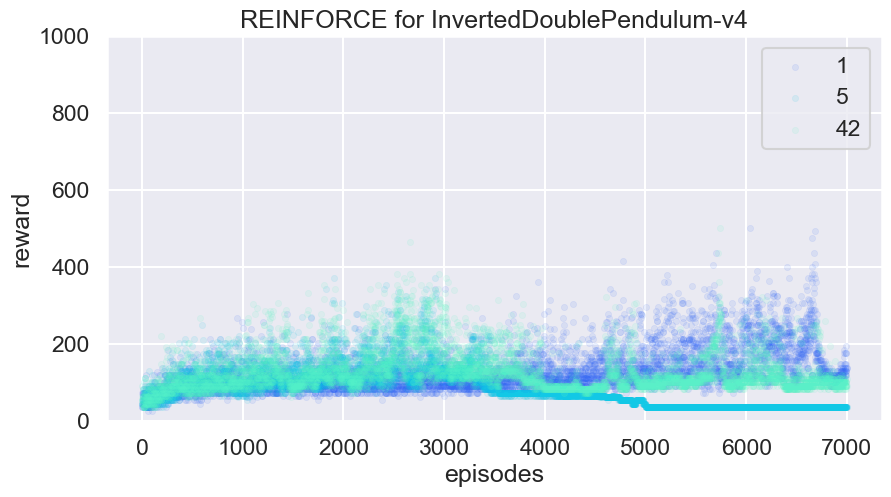

In [104]:
seed_names = [str(i) for i in seeds]
df1 = pd.DataFrame(rewards_over_seeds.T, columns=seed_names)

df1 = df1.reset_index()
plt.rcParams["figure.figsize"] = (10, 5)
fig, axs = plt.subplots(1)
sns.set(style="darkgrid", context="talk", palette="rainbow")

for seed in seed_names:
    # sns.lineplot(x="index", y=seed, data=df1, 
    #                 linewidth = 0.5
    #                 ).set(
    #     title="REINFORCE for InvertedDoublePendulum-v4"
    # )
    sns.scatterplot(x="index", y=seed, data=df1, 
                    linewidth = 0.5,
                    alpha = 0.1,
                    s=20,
                    edgecolor = None, 
                    label = seed
                    ).set(
        title="REINFORCE for InvertedDoublePendulum-v4",
        xlabel = "episodes",
        ylabel = "reward",
        ylim = [0,1000]
    )

axs.legend()

# Test

In [9]:
# Create and wrap the environment
test_env = gym.make("InvertedDoublePendulum-v4", render_mode = "human")
wrapped_test_env = gym.wrappers.RecordEpisodeStatistics(test_env, 50)  # Records episode-reward

total_num_episodes = int(10)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = test_env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = test_env.action_space.shape[0]


# set seed
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Reinitialize agent every seed
#agent = REINFORCE(obs_space_dims, action_space_dims)
reward_over_episodes = []

for episode in range(total_num_episodes):
    # gymnasium v26 requires users to set seed while resetting the environment
    obs, info = wrapped_test_env.reset(seed=seed)

    done = False
    while not done:
        action = agent.sample_action(obs)

        # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
        # These represent the next observation, the reward from the step,
        # if the episode is terminated, if the episode is truncated and
        # additional info from the step
        obs, reward, terminated, truncated, info = wrapped_test_env.step(action)
        #agent.rewards.append(reward)

        # End the episode when either truncated or terminated is true
        #  - truncated: The episode duration reaches max number of timesteps
        #  - terminated: Any of the state space values is no longer finite.
        done = terminated or truncated

    reward_over_episodes.append(wrapped_test_env.return_queue[-1])
    

    if episode % 1 == 0:
        avg_reward = int(np.mean(wrapped_test_env.return_queue))
        print("Episode:", episode, "Average Reward:", avg_reward)

NameError: name 'agent' is not defined

In [7]:
test_env.close()

# Export model

In [31]:
model = agent.net
optimizer = agent.optimizer
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])
torch.save(model.state_dict(), "models/invert_double_pend.pt")

Model's state_dict:
shared_net.0.weight 	 torch.Size([8, 4])
shared_net.0.bias 	 torch.Size([8])
shared_net.2.weight 	 torch.Size([32, 8])
shared_net.2.bias 	 torch.Size([32])
policy_mean_net.0.weight 	 torch.Size([1, 32])
policy_mean_net.0.bias 	 torch.Size([1])
policy_stddev_net.0.weight 	 torch.Size([1, 32])
policy_stddev_net.0.bias 	 torch.Size([1])


# Import

In [23]:
# Create and wrap the environment
test_env = gym.make("InvertedDoublePendulum-v4", render_mode = "human")
wrapped_test_env = gym.wrappers.RecordEpisodeStatistics(test_env, 50)  # Records episode-reward

total_num_episodes = int(10)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = test_env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = test_env.action_space.shape[0]

# Reinitialize agent every seed
imported_agent = REINFORCE(obs_space_dims, action_space_dims)

imported_agent.net.load_state_dict(torch.load("/Users/juri/git/reinforcement_learning/open_ai_gym/models/0.0001_0.99_10000/invert_double_pend_0.0001_0.99_10000_42.pt"))
imported_agent.net.eval()

Policy_Network(
  (shared_net): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (policy_mean_net): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (policy_stddev_net): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [24]:
reward_over_episodes = []
seed = 42

for episode in range(total_num_episodes):
    # gymnasium v26 requires users to set seed while resetting the environment
    obs, info = wrapped_test_env.reset(seed=seed)

    done = False
    while not done:
        action = imported_agent.sample_action(obs)

        # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
        # These represent the next observation, the reward from the step,
        # if the episode is terminated, if the episode is truncated and
        # additional info from the step
        obs, reward, terminated, truncated, info = wrapped_test_env.step(action)
        #agent.rewards.append(reward)

        # End the episode when either truncated or terminated is true
        #  - truncated: The episode duration reaches max number of timesteps
        #  - terminated: Any of the state space values is no longer finite.
        done = terminated or truncated

    reward_over_episodes.append(wrapped_test_env.return_queue[-1])
    

    if episode % 1 == 0:
        avg_reward = int(np.mean(wrapped_test_env.return_queue))
        print("Episode:", episode, "Average Reward:", avg_reward)

Episode: 0 Average Reward: 101
Episode: 1 Average Reward: 97
Episode: 2 Average Reward: 95
Episode: 3 Average Reward: 96
Episode: 4 Average Reward: 96
Episode: 5 Average Reward: 97
Episode: 6 Average Reward: 96
Episode: 7 Average Reward: 95
Episode: 8 Average Reward: 95
Episode: 9 Average Reward: 95


In [37]:
test_env.close()